In [1]:
import sys
if not sys.argv[1] == "-f":
    path = sys.argv[1]
    IF = "01"
    mode = "commandline"
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    path = "/home/amigos/seigyo/hdd2/HDD_2/data/observation/otf/otf_2019/n20191004104447_12CO_2-1_otf_OriKL/"
    savedir = "../../../"
    mode = "notebook"
    %matplotlib inline

In [2]:
sys.path.append("../")

In [3]:
import necstdb
import numpy
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt
from numpy import deg2rad
from tqdm import tqdm
import n2analy
import xarray as xr
from scipy import interpolate#dp shift

In [4]:
plt.rcParams["font.family"] = "Arial,freesans"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 14#23
plt.rcParams["mathtext.fontset"] = "stix" 

In [5]:
ra, dec, ant_time = n2analy.get_radec(os.path.join(path, "wc_list.txt"))

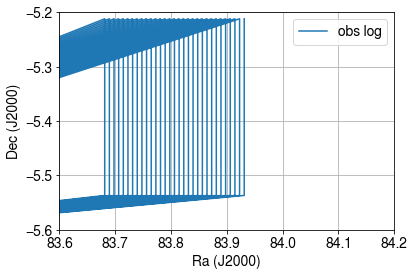

In [6]:
#みたいだけ
ra = numpy.array(ra)/3600
dec = numpy.array(dec)/3600
ra = numpy.where(ra < 0, ra+360, ra)#問題
plt.xlim(83.6, 84.2)
plt.ylim(-5.6, -5.2)
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")
plt.grid()
plt.plot(ra, dec, label="obs log")
plt.legend()
plt.show()

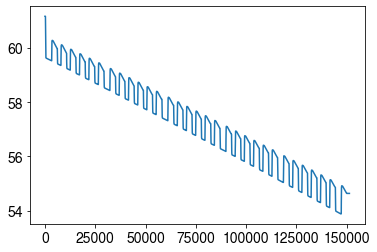

In [7]:
#気象情報の確認
nw = necstdb.opendb(path)
_nw = nw.open_table("status_encoder")
weather_data = _nw.read()
weather_data = numpy.array(weather_data)
plt.plot(weather_data.T[2]/3600)

In [8]:
IF = "04"
data = n2analy.get_data(path, IF)

100%|██████████| 4/4 [00:00<00:00, 32.47it/s]

read end
HOT 1.0
HOT 10.0
HOT 11.0
HOT 13.0
HOT 14.0
HOT 15.0
HOT 16.0
HOT 17.0
HOT 19.0
HOT 2.0
HOT 20.0
HOT 21.0
HOT 22.0
HOT 23.0
HOT 25.0
HOT 26.0
HOT 27.0
HOT 28.0
HOT 29.0
HOT 3.0
HOT 4.0
HOT 5.0
HOT 7.0
HOT 8.0
HOT 9.0
31.0 OFF 0.0 0.0
31.0 ON 0.0 0.0


In [9]:
data["scannum"] = data["scannum"].astype(numpy.float32).astype(numpy.int32)

In [10]:
#chopper wheel

In [11]:
#off integration
off = []
scanmasks = numpy.unique(data["scannum"])
for i in scanmasks:
    _off = n2analy.get_maskedcube(data, "OFF", i)
    off.append(numpy.mean(_off, axis=0))

/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
#hot integration
hot = []
for i in scanmasks:
    _hot = n2analy.get_maskedcube(data, "HOT", i)
    hot.append(numpy.mean(_hot, axis=0))

/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/amigos/.local/share/virtualenvs/analy-Eyq-irNF/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/amigos/.local/share/virtualenvs/analy-E

In [13]:
onmask = data["obsmode"] == "ON"
on_data = data[onmask]

In [14]:
tastar_list = []
for i in tqdm(range(len(on_data["scannum"]))):
    scannum = int(on_data["scannum"][i])
    tastar_list.append(numpy.array(n2analy.chopper_wheel(on_data[i], off[scannum], hot[0], 300)))

100%|██████████| 8137/8137 [00:22<00:00, 367.22it/s]


In [15]:
tastar_list = numpy.array(tastar_list)

In [16]:
#OriKL
lamda_on = 83.80613*3600
#lamda_on = 84.05613 *3600
grid = 30
beta_on = -5.374320*3600
N=31

# #M17SW
# lamda_on = -84.9232  *3600
# grid = 30
# beta_on =  -16.2003 *3600
# N=31

In [17]:
azel_grid = n2analy.make_grid(lamda_on, beta_on, N, grid)

In [18]:
index = []
xffts_timestamp = numpy.array(data[onmask]["t"])
for i in range(len(xffts_timestamp)):
    try:
        a = numpy.where(ant_time >  xffts_timestamp[i])
        #print(a)
        index.append(a[0][0])
    except Exception as e:
        print(e, i)

In [19]:
ant_time = numpy.array(ant_time)

diff_ra = ra[1:] - ra[:-1]
diff_dec = dec[1:] - dec[:-1]
diff_time = ant_time[1:] - ant_time[:-1]

In [20]:
onmask = data["obsmode"] == "ON"
offmask = data["obsmode"] == "OFF"
hotmask = data["obsmode"] == "HOT"
xffts_timestamp = numpy.array(data["t"])[onmask]

In [21]:
xffts_ra = []
xffts_dec = []
xffts_time = []
for n, i in enumerate(index):
    try:
        xffts_ra.append((diff_ra[i-1]/diff_time[i-1]) * (xffts_timestamp[n] - ant_time[i-1]) + ra[i-1])#i-1
        xffts_dec.append((diff_dec[i-1]/diff_time[i-1]) * (xffts_timestamp[n] - ant_time[i-1]) + dec[i-1])#i-1
        xffts_time.append(xffts_timestamp[n])
    except Exception as e:
        print(e, i)
        
xffts_ra = numpy.array(xffts_ra)
xffts_dec = numpy.array(xffts_dec)

In [22]:
tastar_list = xr.DataArray(tastar_list, dims=["t", "GHz"],
                           coords={"t":data["t"][onmask], "GHz":data["GHz"],
                                   "scannum":("t", data["scannum"][onmask]),
                                  "RA":("t", xffts_ra), "DEC":("t", xffts_dec)})

In [23]:
#Doppler tracking
from numpy import deg2rad
dp = n2analy.doppler_nanten()
vobs = [dp.calc_vobs(deg2rad(ra[i]),deg2rad(dec[i]), ant_time[i]) for i in tqdm(range(len(ant_time)))]

100%|██████████| 124/124 [00:14<00:00,  8.35it/s]


In [24]:
vobs = numpy.array(vobs)
_diff_vobs = vobs[1:] - vobs[:-1]

In [25]:
_vobs = []
for n, i in enumerate(index):
    try:
        _vobs.append((_diff_vobs[i-1]/diff_time[i-1]) * (xffts_timestamp[n] - ant_time[i-1]) + vobs[i-1])#i-1
    except Exception as e:
        print(e)
_vobs = numpy.array(_vobs)

In [26]:
#rx info
center_ch = 1.23*32768/2
delta_dv = 0.08302#13CO 2-1          #0.165/2

In [27]:
start = 0
end = delta_dv*32768
dparray = numpy.arange(start, end, delta_dv)*-1

In [28]:
_dparray = dparray + center_ch*delta_dv
shift_ch = _vobs/delta_dv

In [29]:
_ch = numpy.linspace(0, 32768, 32768)
dpshift_tastar = []
xx = tastar_list
for i in tqdm(range(len(xx))):
    f = interpolate.interp1d(_ch, xx[i])
    s_tastar = f(_ch[1000:-1000] + shift_ch[i])
    dpshift_tastar.append(s_tastar)

100%|██████████| 8137/8137 [00:13<00:00, 596.66it/s]


In [30]:
for i in tqdm(range(len(dpshift_tastar))):
    dpshift_tastar[i] = n2analy.baseline_fitting(_dparray[1000:-1000], dpshift_tastar[i], 18000,19000 , 21000, 22000)

100%|██████████| 8137/8137 [00:21<00:00, 386.22it/s]


In [31]:
dptastar_list = xr.DataArray(dpshift_tastar, dims=["t", "Vlsr"],
                           coords={"t":data["t"][onmask], "Vlsr":_dparray[1000:-1000],
                                   "scannum":("t", data["scannum"][onmask]),
                                  "RA":("t", xffts_ra), "DEC":("t", xffts_dec)})

In [32]:
#中間データ保存
#dptastar_list.to_netcdf(f"{savedir}/OriKL.cdf")

In [33]:
#中間データ読み込み
tastar_cube = xr.open_dataarray(f"{savedir}/OriKL.cdf")

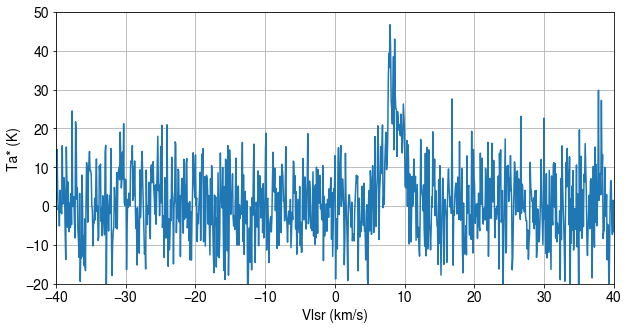

In [47]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(tastar_cube["Vlsr"], tastar_cube[2200])
ax.set_xlim(-40, 40)
ax.set_ylim(-20, 50)
ax.set_xlabel("Vlsr (km/s)")
ax.set_ylabel("Ta* (K)")
ax.grid(True)